In [9]:
#This script takes a initial date and final date and downloads the files needed to compute the wave activity flux (WAF)
#for that given period. NCEP/NCAR Reanalysis (Kalnay etal 1996)are used 

#libraries needed
import urllib.request
from bs4 import BeautifulSoup

def clean():   #clean enviroment
    import os
    os.system("rm -f /tmp/*.gz /tmp/*.nc")
    
def descarga_nc( mesi, diai, mesf, diaf, aniof, variable_entrada, variable_salida, tipo):
    #tipo controls type of data: 2 for anomalies, 3 for climatology
    # Open NCEP NCAR to access to lik to data

        url = 'http://www.esrl.noaa.gov/psd/cgi-bin/data/composites/comp.day.pl?var='+variable_entrada+'&level=250mb&iy[1]=&im[1]=&id[1]=&iy[2]=&im[2]=&id[2]=&iy[3]=&im[3]=&id[3]=&iy[4]=&im[4]=&id[4]=&iy[5]=&im[5]=&id[5]=&iy[6]=&im[6]=&id[6]=&iy[7]=&im[7]=&id[7]=&iy[8]=&im[8]=&id[8]=&iy[9]=&im[9]=&id[9]=&iy[10]=&im[10]=&id[10]=&iy[11]=&im[11]=&id[11]=&iy[12]=&im[12]=&id[12]=&iy[13]=&im[13]=&id[13]=&iy[14]=&im[14]=&id[14]=&iy[15]=&im[15]=&id[15]=&iy[16]=&im[16]=&id[16]=&iy[17]=&im[17]=&id[17]=&iy[18]=&im[18]=&id[18]=&iy[19]=&im[19]=&id[19]=&iy[20]=&im[20]=&id[20]=&monr1='+str(mesi)+'&dayr1='+str(diai)+'&monr2='+str(mesf)+'&dayr2='+str(diaf)+'&iyr[1]='+str(aniof)+'&filenamein=&plotlabel=&lag=0&labelc=Color&labels=Shaded&type='+str(tipo)+'&scale=&label=0&cint=&lowr=&highr=&istate=0&proj=ALL&xlat1=&xlat2=&xlon1=&xlon2=&custproj=Cylindrical+Equidistant&level1=1000mb&level2=10mb&Submit=Create+Plot'
        response = urllib.request.urlopen(url)
        data = response.read()      # a `bytes` object

        soup = BeautifulSoup(data,'html.parser') #is an xml, beautifull has a module to manage it
        link = soup.findAll('img')[-1]['src']
        #A very inefficient way to get the nc file

        link=list(link)
        link[-3]='n'
        link[-2]='c'
        link[-1]=''
        
        #get nc file save as netcdf
        ruta = "./tmp/"
        urllib.request.urlretrieve('http://www.esrl.noaa.gov'+"".join(link), ruta+variable_salida+'.nc')
    
#begin        

clean()

#initial date
iniy = 2016
inim = 11
inid = 11

#final date
finy = 2016
finm = 11
find = 20

#download: geopotential height, u and v climatology for the selected period
#          geopotential height anomalies

variables = ['Zonal+Wind','Meridional+Wind','Geopotential+Height']

out_var = ['zonalw_climo','meridw_climo','hgt_climo','hgt']

for i in range(0,3):
    if i==2: # download climo and anomaly for geopotential
        descarga_nc(inim,inid,finm,find,finy,variables[i],out_var[i],3)
        descarga_nc(inim,inid,finm,find,finy,variables[i],out_var[i+1],2)
    descarga_nc(inim,inid,finm,find,finy,variables[i],out_var[i],3)




In [10]:
# manipulation of netCDF files
import netCDF4
import numpy as np

def manipular_nc(archivo,variable):
    dataset = netCDF4.Dataset(archivo, 'r')
    var_out = dataset.variables[variable][:]
    lon = dataset.variables['lon'][:]
    lat = dataset.variables['lat'][:]
    dataset.close()
    return var_out, lon, lat

#begin

ruta = "./tmp/"

out_var = ['zonalw_climo','meridw_climo','hgt_climo','hgt']

nc_var = ['uwnd','vwnd','hgt']

[uclm,lon,lat] = manipular_nc(ruta+out_var[0]+'.nc',nc_var[0])

[vclm,lon,lat] = manipular_nc(ruta+out_var[1]+'.nc',nc_var[1])

[zclm,lon,lat] = manipular_nc(ruta+out_var[2]+'.nc',nc_var[2])

[zaa,lon,lat] = manipular_nc(ruta+out_var[3]+'.nc',nc_var[2])  #zaa [1 nlat nlon]

#restringe domain to latitudes south to 0 (to avoid problems with sin (0°))
index_lat = np.where(lat<0)
zaa = zaa[0,index_lat,:]
lat = lat[index_lat]
uclm = uclm[0,index_lat,:]
vclm = vclm[0,index_lat,:]


In [11]:
#computation of plum fluxes. Script adapted from Kazuaki Nishii and Hisashi Nakamura
import math
import numpy as np

def c_diff(arr, h, dim, cyclic = False):  #compute derivate of array variable respect to h associated to dim
    #adapted from kuchaale script
    ndim = arr.ndim
    lst = [i for i in range(ndim)]

    lst[dim], lst[0] = lst[0], lst[dim]
    rank = lst 
    arr = np.transpose(arr, tuple(rank))

    if ndim == 3:
        shp = (arr.shape[0]-2,1,1)
    elif ndim == 4:
        shp = (arr.shape[0]-2,1,1,1)
    
    d_arr = np.copy(arr)
    if not cyclic:  
        d_arr[0,...] = (arr[1,...]-arr[0,...])/(h[1]-h[0])
        d_arr[-1,...] = (arr[-1,...]-arr[-2,...])/(h[-1]-h[-2])
        d_arr[1:-1,...] = (arr[2:,...]-arr[0:-2,...])/np.reshape(h[2:]-h[0:-2], shp)

    elif cyclic:
        d_arr[0,...] = (arr[1,...]-arr[-1,...])/(h[1]-h[-1])
        d_arr[-1,...] = (arr[0,...]-arr[-2,...])/(h[0]-h[-2])
        d_arr[1:-1,...] = (arr[2:,...]-arr[0:-2,...])/np.reshape(h[2:]-h[0:-2], shp)

    d_arr = np.transpose(d_arr, tuple(rank))

    return d_arr

#begin

[xxx,nlats,nlons] = zaa.shape #get dimensions

#gas constant
Ra = 290

#earth radius
a = 6400000

coslat = np.cos(lat*3.14/180)
sinlat = np.sin(lat*3.14/180)

#Coriolis parameter
f = 2*7.24/100000*sinlat
f0 = 2*7.24/100000*math.sin(43*3.14/180)

#gravity
g = 9.8

# unit [Pa]
lev = 20000

# basic state (climatology): uclm vclm zclm

# anomalies zaa

# QG stream function
psiaa = g/np.transpose(np.tile(f,(nlons,1)))*zaa

# magnitude of basic state wind speed
magU = np.sqrt(np.add(np.power(uclm,2),np.power(vclm,2)))

#psi derivatives
dpsidlon = c_diff(psiaa,lon,2)
ddpsidlonlon = c_diff(dpsidlon,lon,2)

dpsidlat = c_diff(psiaa,lat,1)
ddpsidlatlat = c_diff(dpsidlat,lat,1)
ddpsidlatlon = c_diff(dpsidlat,lon,2)

termxu = dpsidlon*dpsidlon-psiaa*ddpsidlonlon

termxv = dpsidlon*dpsidlat-ddpsidlatlon*psiaa

termyv = dpsidlat*dpsidlat-psiaa*ddpsidlatlat

# "p" is normalized by 1000hPa
coeff1=np.transpose(np.tile(coslat,(nlons,1)))*(lev/100000)/(2*magU)
#x-component

px = coeff1/(a*a*np.transpose(np.tile(coslat,(nlons,1))))*( uclm*termxu/np.transpose(np.tile(coslat,(nlons,1))) + vclm*termxv)

#y-component

py = coeff1/(a*a)*( uclm/np.transpose(np.tile(coslat,(nlons,1)))*termxv + vclm*termyv)


/home/osman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/home/osman/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/home/osman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/osman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:53: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the N

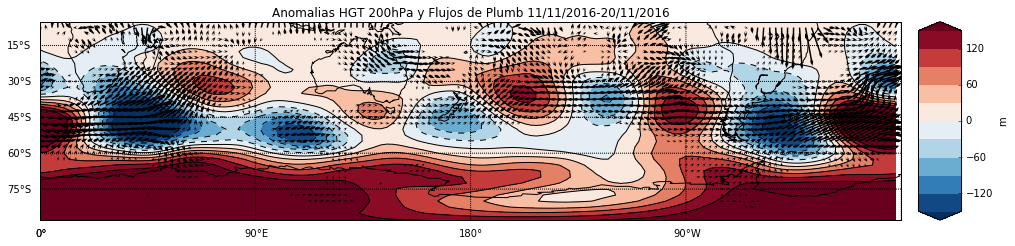

In [12]:
#plot flux along with hgt anomalies

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm
import numpy as np
from numpy import ma  #mask smaller values

%matplotlib inline

# create figure, add axes
fig1 = plt.figure(figsize=(16,20),dpi=300)  #fig size in inches
ax = fig1.add_axes([0.1,0.1,0.8,0.8])

mapproj = bm.Basemap(projection='cyl',
                     llcrnrlat=-88.0, llcrnrlon=0.0,
                     urcrnrlat=-5.0, urcrnrlon=360.0)    #projection and map limits
#mapproj = bm.Basemap(projection='spstere',\
#            boundinglat=0,lon_0=120,resolution='l') 

mapproj.drawcoastlines()          # coast
mapproj.drawparallels(np.array([-75, -60, -45, -30,-15]), labels=[1,0,0,0])    #draw parallels
mapproj.drawmeridians(np.array([-180, -90, 0, 90, 180]), labels=[0,0,0,1])     #draw meridians

lonall, latall = np.meshgrid(lon, lat)          #array of grid
lonproj, latproj = mapproj(lonall, latall)      #poject grid

# set desired contour levels.
clevs = np.arange(-150,180,30)          

barra = plt.cm.RdBu_r #colorbar

CS1 = mapproj.contourf(lonproj, latproj,zaa[0,:,:],clevs,cmap=barra,extend='both') #extended generate pretty colorbar
#color lower and upper colorbar triangles
barra.set_under(barra(0))
barra.set_over(barra(barra.N-1))

# add colorbar
cb = mapproj.colorbar(CS1,"right")
cb.set_label('m')

#contoour levels
mapproj.contour(lonproj, latproj,zaa[0,:,:],clevs,colors = 'k')

#mask wind data
M = np.sqrt(np.add(np.power(px,2),np.power(py,2))) < 0.001

#mask array
px_mask = ma.array(px,mask = M)
py_mask = ma.array(py,mask = M)

#apply mask: very inefficient way
px_mask[px_mask.mask] = np.nan
py_mask[py_mask.mask] = np.nan

#print title
ax.set_title('Anomalias HGT 200hPa '+str(inid)+'/'+str(inim)+'/'+str(iniy)+'-'+str(find)+'/'+str(finm)+'/'+str(finy))
#show image
#plt.show()
#save figure
fig1.savefig('hgt_'+str(inid)+str(inim)+str(iniy)+'-'+str(find)+str(finm)+str(finy)+'.jpg',dpi=300,bbox_inches='tight',orientation='landscape',papertype='A4')
#tight option adjuts paper size to figure

#plot plumb fluxes and save again

#plot vectors
Q = mapproj.quiver(lonproj[2:-1,:],latproj[2:-1,:],px_mask[0,2:-1,:],py_mask[0,2:-1,:],width=1.7e-3,
                   headwidth=2,#headwidht (default3)
                   headlength=2.5)  # (default5)
ax.set_title('Anomalias HGT 200hPa y Flujos de Plumb '+str(inid)+'/'+str(inim)+'/'+str(iniy)+'-'+str(find)+'/'+str(finm)+'/'+str(finy))
#save figure
fig1.savefig('hgt_plumb_'+str(inid)+str(inim)+str(iniy)+'-'+str(find)+str(finm)+str(finy)+'.jpg',dpi=300,bbox_inches='tight',orientation='landscape',papertype='A4')
#tight option adjuts paper size to figure
